**Quatrième réseau** :  
     - Similaire au troisième, mais avec des images de 32x32 pixels, un DataGen, et des images modifiées en termes de contraste et de luminosité.  
    - Les images sont redimensionnées à 32x32 pixels.  
    - Utilisation d'un générateur de données (DataGen) pour augmenter les données via des rotations, inversions (flip), ajustements de contraste et de luminosité.  
    - Validation croisée à 10 plis  
     - Classes: ['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS']

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import collections
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

from keras.layers import Dropout


#Wilcoxon Test
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import wilcoxon

#Utilizado para guardar modelos y cargarlos
import joblib

import shap

import cv2

#Entrenamiento
batch_size = 64
nb_classes = 3
epochs = 50
crossValidationSplit = 10
# Scaling input image to theses dimensions
img_rows, img_cols = 32, 32

In [2]:
def preprocesar_imagen(imagen_path):
    # Cargar la imagen utilizando OpenCV
    imagen = cv2.imread(imagen_path)

    # Convertir la imagen a escala de grises
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    alpha = 1.3  # factor de contraste
    beta = -80    # factor de brillo
    imagen_ajustada = cv2.convertScaleAbs(imagen_gris, alpha=alpha, beta=beta)

    imagen_final = cv2.resize(imagen_ajustada, (img_rows, img_cols), interpolation=cv2.INTER_AREA)

    return imagen_final


In [3]:
def load_data(ruta):
    name_classes = ['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS']
    X, y = [], []

    # Listar las carpetas principales
    base_dirs = [ruta + r'\train', ruta + r'\val', ruta + r'\test']

    for base_dir in base_dirs:
        for class_name in ['NORMAL', 'PNEUMONIA']:
            path = rf'{base_dir}\{class_name}\*.jpeg'
            for filename in glob.glob(path):
                im = preprocesar_imagen(filename)
                X.append(image.img_to_array(im))
                
                if class_name == 'NORMAL':
                    y.append(0)  # Clase 0: NORMAL
                elif 'bacteria' in filename.lower():
                    y.append(1)  # Clase 1: PNEUMONIA_BACTERIA
                elif 'virus' in filename.lower():
                    y.append(2)  # Clase 2: PNEUMONIA_VIRUS

    input_shape = (img_rows, img_cols, 1)
    return np.array(X), np.array(y), input_shape


In [4]:
def cnn_model(input_shape,nb_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Rescaling(1. / 255)(inputs)

    x = layers.Conv2D(32, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Flatten()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(nb_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [5]:
def plot_symbols(X,y,n=15):
    index = np.random.randint(len(y), size=n)
    plt.figure(figsize=(n, 3))
    for i in np.arange(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[index[i],:,:,0])
        plt.gray()
        ax.set_title('{}-{}'.format(y[index[i]],index[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [6]:
def enregistrer_tableau_dans_txt(tableau, nom_fichier):
    """
    Enregistre les éléments d'un tableau dans un fichier .txt.

    Args:
        tableau (list): Liste des éléments à enregistrer.
        nom_fichier (str): Nom du fichier (doit inclure l'extension .txt).
    
    Returns:
        None
    """
    try:
        # Ouvrir le fichier en mode écriture
        with open(nom_fichier, 'w', encoding='utf-8') as fichier:
            # Écrire chaque élément du tableau sur une nouvelle ligne
            for element in tableau:
                fichier.write(str(element) + '\n')
        print(f"Tableau enregistré avec succès dans '{nom_fichier}'")
    except Exception as e:
        print(f"Erreur lors de l'enregistrement du fichier : {e}")

(5856, 32, 32, 1) échantillons d'entraînement
32 x 32 taille de l'image
(32, 32, 1) input_shape
50 epochs


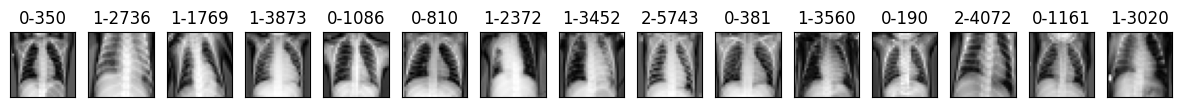

Nombre d'images générées: 5312
x_train (5270, 32, 32, 1) x_test (586, 32, 32, 1)
y_train (5270,) y_test (586,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 45ms/step - accuracy: 0.4800 - loss: 1.0559 - val_accuracy: 0.5990 - val_loss: 0.9208
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.5156 - loss: 0.9553 - val_accuracy: 0.5785 - val_loss: 0.9141
Epoch 3/50
82/82 - 2s - 24ms/step - accuracy: 0.6306 - loss: 0.8240 - val_accuracy: 0.6775 - val_loss: 0.7153
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.6094 - loss: 0.8157 - val_accuracy: 0.6758 - val_loss: 0.6984
Epoch 5/50
82/82 - 2s - 23ms/step - accuracy: 0.6711 - loss: 0.7522 - val_accuracy: 0.7218 - val_loss: 0.6609
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.7344 - loss: 0.5718 - val_accuracy: 0.7014 - val_loss: 0.6764
Epoch 7/50
82/82 - 2s - 25ms/step - accuracy: 0.6905 - loss: 0.7202 - val_accuracy: 0.7116 - val_loss: 0.6627
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.5781 - loss: 0.7714 - val_accuracy: 0.6860 - val_loss: 0.6818
Epoch 9/50
82/82 - 2s - 24ms/step - accuracy: 0.7032 - loss: 0.6892 - val_accuracy: 0.6860 - val_loss: 0.6809
Epoch 10/

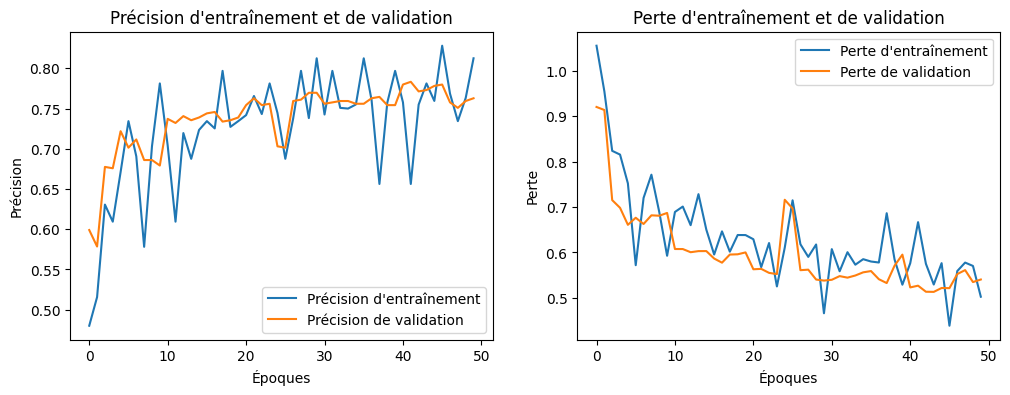

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8172 - loss: 0.4131
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 1:
perte: 0.54 précision: 0.76
AUC 0.8968
Prédictions
Counter({np.int64(1): 307, np.int64(0): 189, np.int64(2): 90}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.79      0.94      0.86       159
Pneumonia_bacteriana       0.78      0.86      0.81       278
     Pneumonia_viral       0.66      0.40      0.49       149

            accuracy                           0.76       586
           macro avg       0.74      0.73      0.72       586
        weighted avg       0.75      0.76      0.75       586

Matrice de confusion


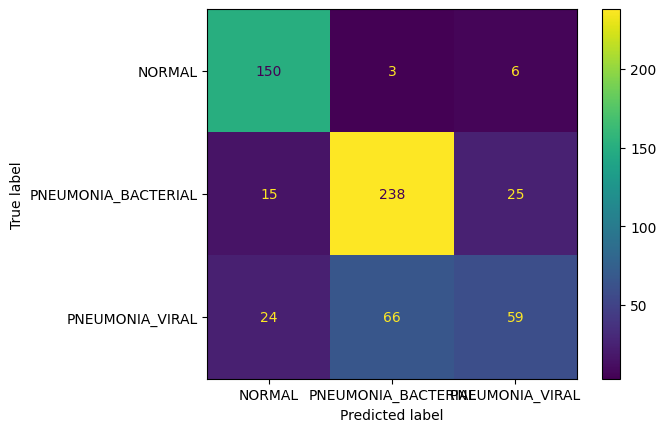

Nombre d'images générées: 5312
x_train (5270, 32, 32, 1) x_test (586, 32, 32, 1)
y_train (5270,) y_test (586,)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 43ms/step - accuracy: 0.4908 - loss: 1.0353 - val_accuracy: 0.4556 - val_loss: 1.0989
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.4531 - loss: 1.0806 - val_accuracy: 0.5307 - val_loss: 0.9851
Epoch 3/50
82/82 - 2s - 24ms/step - accuracy: 0.6393 - loss: 0.8017 - val_accuracy: 0.6365 - val_loss: 0.8257
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.6250 - loss: 0.8538 - val_accuracy: 0.6519 - val_loss: 0.7906
Epoch 5/50
82/82 - 2s - 24ms/step - accuracy: 0.6725 - loss: 0.7433 - val_accuracy: 0.7116 - val_loss: 0.6450
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.7188 - loss: 0.6623 - val_accuracy: 0.7218 - val_loss: 0.6356
Epoch 7/50
82/82 - 2s - 25ms/step - accuracy: 0.6904 - loss: 0.7084 - val_accuracy: 0.7150 - val_loss: 0.6255
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.6719 - loss: 0.6971 - val_accuracy: 0.7184 - val_loss: 0.6594
Epoch 9/50
82/82 - 2s - 24ms/step - accuracy: 0.6992 - loss: 0.6934 - val_accuracy: 0.7389 - val_loss: 0.6736
Epoch 10/

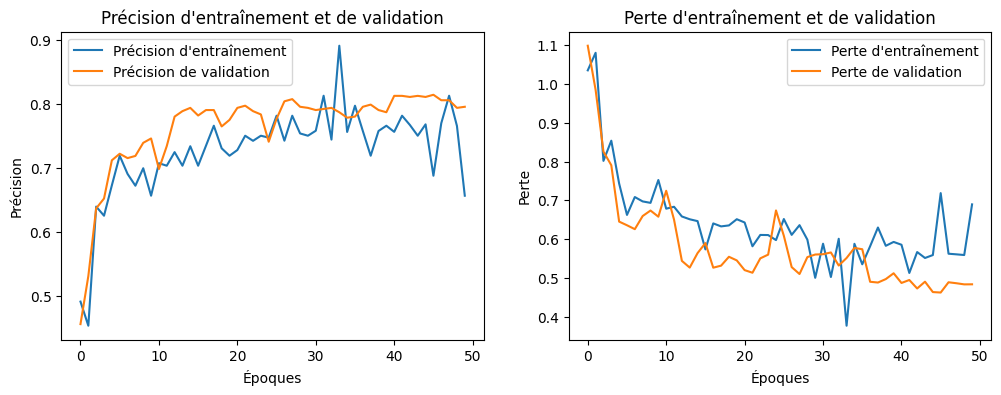

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8458 - loss: 0.3737
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 2:
perte: 0.48 précision: 0.80
AUC 0.9187
Prédictions
Counter({np.int64(1): 325, np.int64(0): 177, np.int64(2): 84}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.85      0.95      0.90       159
Pneumonia_bacteriana       0.77      0.90      0.83       278
     Pneumonia_viral       0.76      0.43      0.55       149

            accuracy                           0.80       586
           macro avg       0.80      0.76      0.76       586
        weighted avg       0.79      0.80      0.78       586

Matrice de confusion


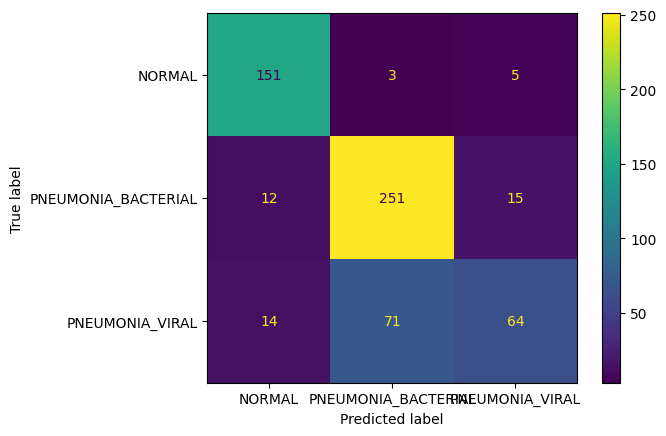

Nombre d'images générées: 5312
x_train (5270, 32, 32, 1) x_test (586, 32, 32, 1)
y_train (5270,) y_test (586,)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 44ms/step - accuracy: 0.4800 - loss: 1.0525 - val_accuracy: 0.6382 - val_loss: 0.9219
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.6250 - loss: 0.9025 - val_accuracy: 0.6485 - val_loss: 0.9085
Epoch 3/50
82/82 - 2s - 24ms/step - accuracy: 0.6297 - loss: 0.8331 - val_accuracy: 0.6348 - val_loss: 0.7938
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.6875 - loss: 0.7079 - val_accuracy: 0.6143 - val_loss: 0.8601
Epoch 5/50
82/82 - 2s - 25ms/step - accuracy: 0.6583 - loss: 0.7676 - val_accuracy: 0.6280 - val_loss: 0.8264
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.7188 - loss: 0.7538 - val_accuracy: 0.6365 - val_loss: 0.8084
Epoch 7/50
82/82 - 2s - 25ms/step - accuracy: 0.6775 - loss: 0.7214 - val_accuracy: 0.6792 - val_loss: 0.7606
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.7344 - loss: 0.7473 - val_accuracy: 0.6894 - val_loss: 0.7400
Epoch 9/50
82/82 - 2s - 25ms/step - accuracy: 0.6896 - loss: 0.7201 - val_accuracy: 0.7150 - val_loss: 0.6512
Epoch 10/

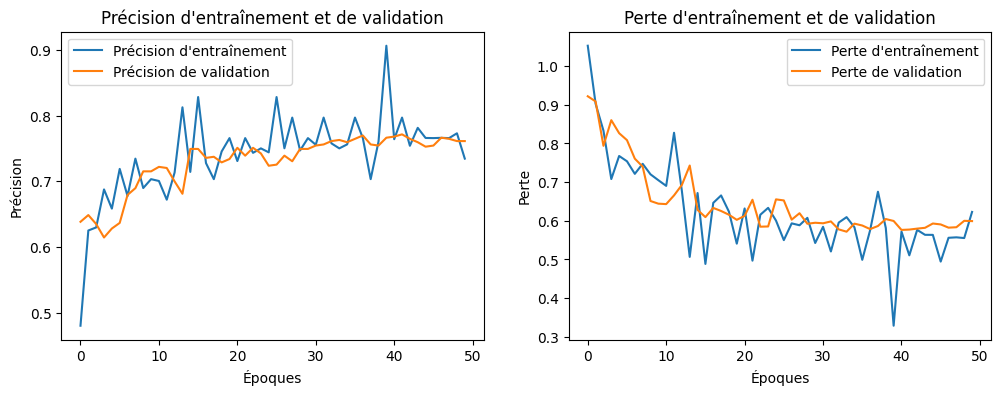

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8126 - loss: 0.4659 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 3:
perte: 0.60 précision: 0.76
AUC 0.8785
Prédictions
Counter({np.int64(1): 324, np.int64(0): 177, np.int64(2): 85}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.83      0.92      0.88       159
Pneumonia_bacteriana       0.74      0.87      0.80       278
     Pneumonia_viral       0.68      0.39      0.50       149

            accuracy                           0.76       586
           macro avg       0.75      0.73      0.72       586
        weighted avg       0.75      0.76      0.74       586

Matrice de confusion


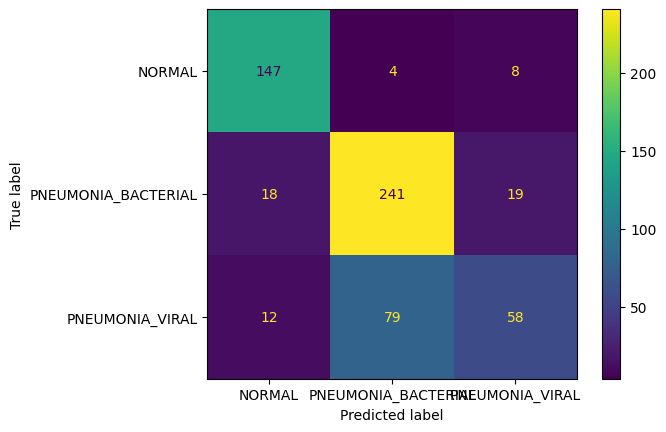

Nombre d'images générées: 5312
x_train (5270, 32, 32, 1) x_test (586, 32, 32, 1)
y_train (5270,) y_test (586,)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 44ms/step - accuracy: 0.4693 - loss: 1.0623 - val_accuracy: 0.4846 - val_loss: 0.9640
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.5938 - loss: 0.9050 - val_accuracy: 0.5324 - val_loss: 0.9541
Epoch 3/50
82/82 - 2s - 25ms/step - accuracy: 0.6168 - loss: 0.8510 - val_accuracy: 0.6433 - val_loss: 0.7657
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.7188 - loss: 0.7427 - val_accuracy: 0.6331 - val_loss: 0.8011
Epoch 5/50
82/82 - 2s - 26ms/step - accuracy: 0.6675 - loss: 0.7530 - val_accuracy: 0.7253 - val_loss: 0.6509
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.5938 - loss: 0.8524 - val_accuracy: 0.7253 - val_loss: 0.6498
Epoch 7/50
82/82 - 2s - 25ms/step - accuracy: 0.6879 - loss: 0.7137 - val_accuracy: 0.6911 - val_loss: 0.6431
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.6875 - loss: 0.7661 - val_accuracy: 0.7065 - val_loss: 0.6308
Epoch 9/50
82/82 - 2s - 24ms/step - accuracy: 0.6927 - loss: 0.7031 - val_accuracy: 0.7184 - val_loss: 0.6479
Epoch 10/

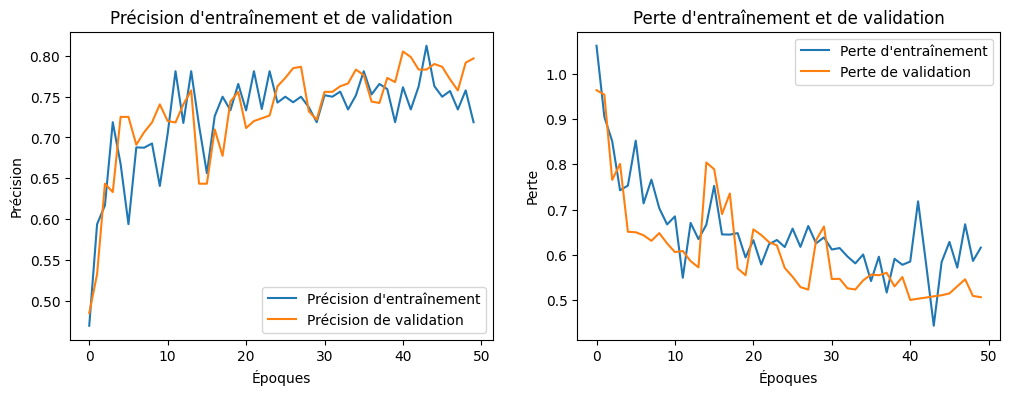

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8430 - loss: 0.3844 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 4:
perte: 0.51 précision: 0.80
AUC 0.9144
Prédictions
Counter({np.int64(1): 288, np.int64(0): 182, np.int64(2): 116}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.84      0.96      0.89       158
Pneumonia_bacteriana       0.81      0.83      0.82       278
     Pneumonia_viral       0.72      0.55      0.62       150

            accuracy                           0.80       586
           macro avg       0.79      0.78      0.78       586
        weighted avg       0.79      0.80      0.79       586

Matrice de confusion


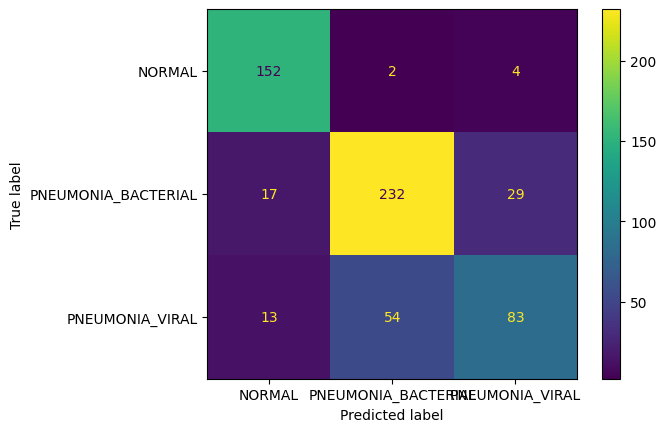

Nombre d'images générées: 5312
x_train (5270, 32, 32, 1) x_test (586, 32, 32, 1)
y_train (5270,) y_test (586,)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 46ms/step - accuracy: 0.4752 - loss: 1.0530 - val_accuracy: 0.6451 - val_loss: 0.8981
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.6250 - loss: 0.9065 - val_accuracy: 0.6485 - val_loss: 0.8762
Epoch 3/50
82/82 - 2s - 25ms/step - accuracy: 0.6166 - loss: 0.8512 - val_accuracy: 0.6638 - val_loss: 0.7484
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.6250 - loss: 0.8566 - val_accuracy: 0.6314 - val_loss: 0.7790
Epoch 5/50
82/82 - 2s - 25ms/step - accuracy: 0.6581 - loss: 0.7672 - val_accuracy: 0.7031 - val_loss: 0.6473
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.7500 - loss: 0.5969 - val_accuracy: 0.7133 - val_loss: 0.6375
Epoch 7/50
82/82 - 2s - 25ms/step - accuracy: 0.6784 - loss: 0.7291 - val_accuracy: 0.7150 - val_loss: 0.6334
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.6875 - loss: 0.6445 - val_accuracy: 0.7167 - val_loss: 0.6212
Epoch 9/50
82/82 - 2s - 25ms/step - accuracy: 0.6838 - loss: 0.7183 - val_accuracy: 0.7457 - val_loss: 0.5865
Epoch 10/

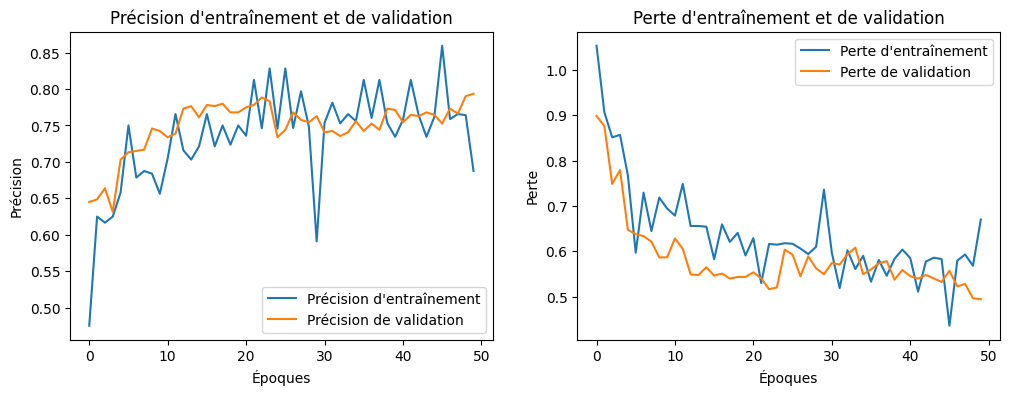

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8353 - loss: 0.3834
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 5:
perte: 0.49 précision: 0.79
AUC 0.9090
Prédictions
Counter({np.int64(1): 318, np.int64(0): 170, np.int64(2): 98}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.90      0.97      0.93       158
Pneumonia_bacteriana       0.77      0.88      0.82       278
     Pneumonia_viral       0.69      0.45      0.55       150

            accuracy                           0.79       586
           macro avg       0.79      0.77      0.77       586
        weighted avg       0.78      0.79      0.78       586

Matrice de confusion


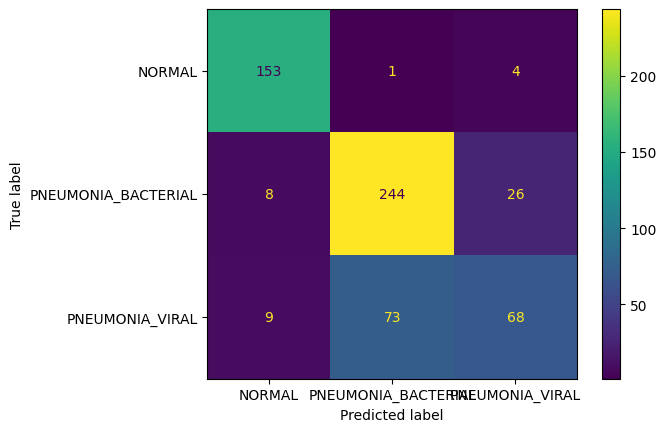

Nombre d'images générées: 5312
x_train (5270, 32, 32, 1) x_test (586, 32, 32, 1)
y_train (5270,) y_test (586,)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 48ms/step - accuracy: 0.4758 - loss: 1.0588 - val_accuracy: 0.4966 - val_loss: 0.9802
Epoch 2/50
82/82 - 0s - 2ms/step - accuracy: 0.4219 - loss: 1.0194 - val_accuracy: 0.6092 - val_loss: 0.9905
Epoch 3/50
82/82 - 2s - 24ms/step - accuracy: 0.6153 - loss: 0.8447 - val_accuracy: 0.6177 - val_loss: 0.8792
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.7344 - loss: 0.7304 - val_accuracy: 0.6143 - val_loss: 0.8863
Epoch 5/50
82/82 - 2s - 25ms/step - accuracy: 0.6698 - loss: 0.7445 - val_accuracy: 0.6160 - val_loss: 0.8339
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.5156 - loss: 0.8481 - val_accuracy: 0.6297 - val_loss: 0.8090
Epoch 7/50
82/82 - 2s - 24ms/step - accuracy: 0.6771 - loss: 0.7160 - val_accuracy: 0.7031 - val_loss: 0.7210
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.8125 - loss: 0.6262 - val_accuracy: 0.6809 - val_loss: 0.7635
Epoch 9/50
82/82 - 2s - 25ms/step - accuracy: 0.7015 - loss: 0.6874 - val_accuracy: 0.6980 - val_loss: 0.7357
Epoch 10/

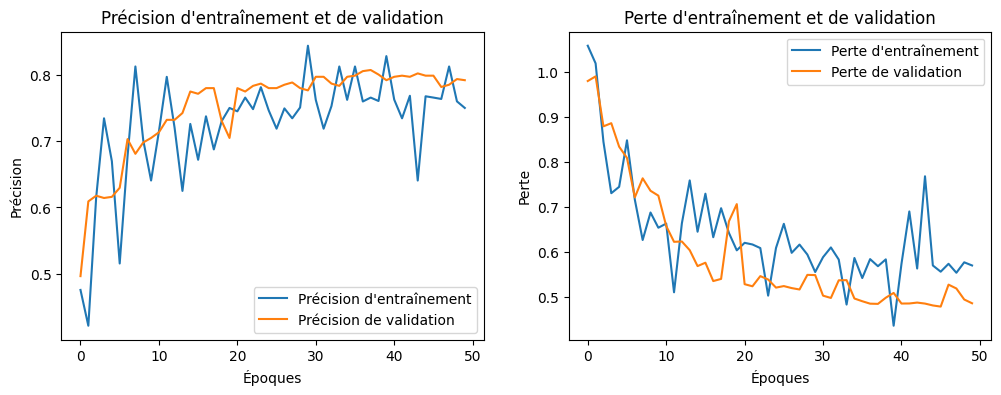

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8325 - loss: 0.4104
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 6:
perte: 0.49 précision: 0.79
AUC 0.9175
Prédictions
Counter({np.int64(1): 337, np.int64(0): 152, np.int64(2): 97}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.94      0.91      0.92       158
Pneumonia_bacteriana       0.74      0.90      0.81       278
     Pneumonia_viral       0.73      0.47      0.57       150

            accuracy                           0.79       586
           macro avg       0.80      0.76      0.77       586
        weighted avg       0.79      0.79      0.78       586

Matrice de confusion


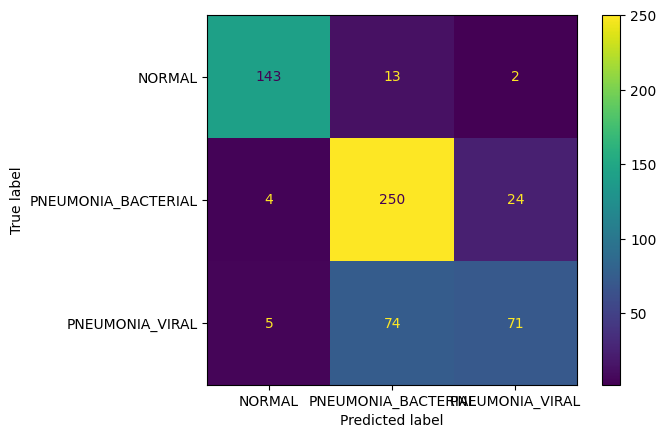

Nombre d'images générées: 5312
x_train (5271, 32, 32, 1) x_test (585, 32, 32, 1)
y_train (5271,) y_test (585,)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 46ms/step - accuracy: 0.4698 - loss: 1.0649 - val_accuracy: 0.4752 - val_loss: 1.0167
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.5312 - loss: 1.0021 - val_accuracy: 0.4752 - val_loss: 1.0132
Epoch 3/50
82/82 - 2s - 24ms/step - accuracy: 0.5973 - loss: 0.8870 - val_accuracy: 0.6479 - val_loss: 0.7519
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.5781 - loss: 0.8049 - val_accuracy: 0.6667 - val_loss: 0.7230
Epoch 5/50
82/82 - 2s - 25ms/step - accuracy: 0.6568 - loss: 0.7682 - val_accuracy: 0.6940 - val_loss: 0.6678
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.7188 - loss: 0.6139 - val_accuracy: 0.6838 - val_loss: 0.6824
Epoch 7/50
82/82 - 2s - 24ms/step - accuracy: 0.6820 - loss: 0.7282 - val_accuracy: 0.6803 - val_loss: 0.6941
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.6875 - loss: 0.6307 - val_accuracy: 0.6752 - val_loss: 0.6934
Epoch 9/50
82/82 - 2s - 25ms/step - accuracy: 0.6906 - loss: 0.7140 - val_accuracy: 0.7043 - val_loss: 0.6485
Epoch 10/

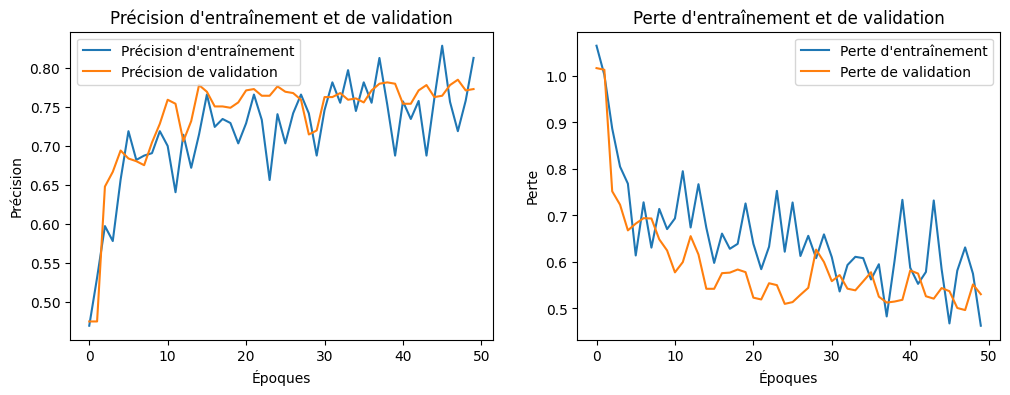

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8198 - loss: 0.4120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 7:
perte: 0.53 précision: 0.77
AUC 0.9042
Prédictions
Counter({np.int64(1): 295, np.int64(0): 188, np.int64(2): 102}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.80      0.95      0.87       158
Pneumonia_bacteriana       0.79      0.83      0.81       278
     Pneumonia_viral       0.69      0.47      0.56       149

            accuracy                           0.77       585
           macro avg       0.76      0.75      0.74       585
        weighted avg       0.76      0.77      0.76       585

Matrice de confusion


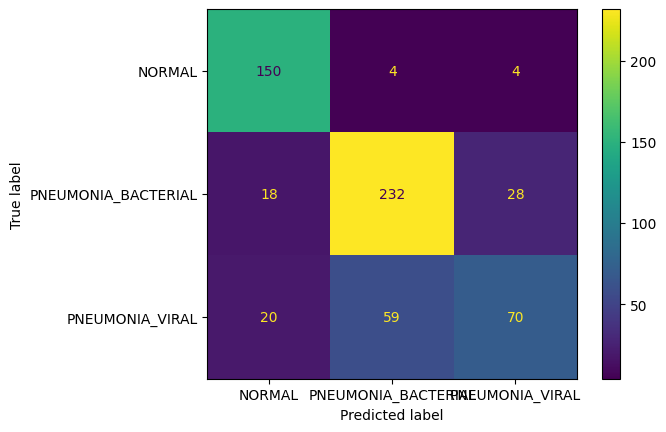

Nombre d'images générées: 5312
x_train (5271, 32, 32, 1) x_test (585, 32, 32, 1)
y_train (5271,) y_test (585,)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 46ms/step - accuracy: 0.5022 - loss: 1.0287 - val_accuracy: 0.6496 - val_loss: 0.7919
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.5312 - loss: 0.8859 - val_accuracy: 0.6564 - val_loss: 0.7738
Epoch 3/50
82/82 - 2s - 26ms/step - accuracy: 0.6443 - loss: 0.7976 - val_accuracy: 0.6530 - val_loss: 0.7684
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.6094 - loss: 0.7999 - val_accuracy: 0.6547 - val_loss: 0.7484
Epoch 5/50
82/82 - 2s - 25ms/step - accuracy: 0.6710 - loss: 0.7436 - val_accuracy: 0.6291 - val_loss: 0.7977
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.7344 - loss: 0.7504 - val_accuracy: 0.6325 - val_loss: 0.7867
Epoch 7/50
82/82 - 2s - 25ms/step - accuracy: 0.6862 - loss: 0.7148 - val_accuracy: 0.6684 - val_loss: 0.7285
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.7344 - loss: 0.6491 - val_accuracy: 0.6803 - val_loss: 0.6928
Epoch 9/50
82/82 - 2s - 25ms/step - accuracy: 0.6889 - loss: 0.7219 - val_accuracy: 0.6581 - val_loss: 0.7268
Epoch 10/

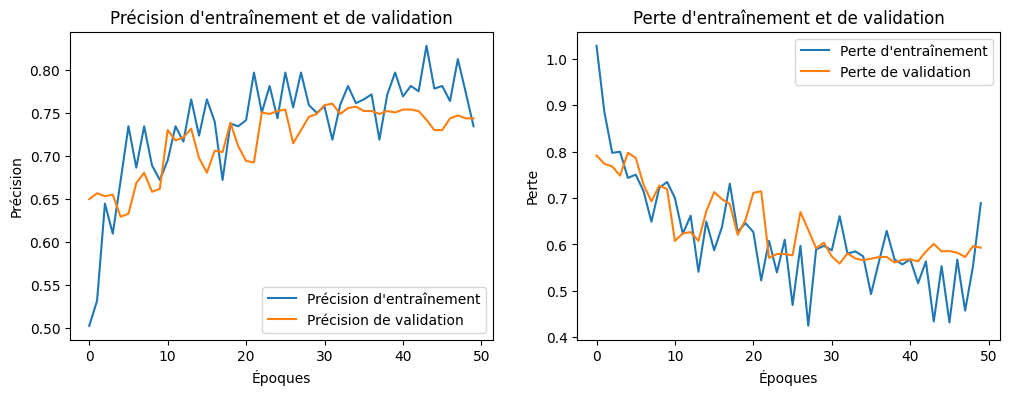

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7999 - loss: 0.4564
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 8:
perte: 0.59 précision: 0.74
AUC 0.8792
Prédictions
Counter({np.int64(1): 337, np.int64(0): 185, np.int64(2): 63}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.80      0.94      0.86       158
Pneumonia_bacteriana       0.73      0.88      0.80       278
     Pneumonia_viral       0.67      0.28      0.40       149

            accuracy                           0.74       585
           macro avg       0.73      0.70      0.69       585
        weighted avg       0.73      0.74      0.71       585

Matrice de confusion


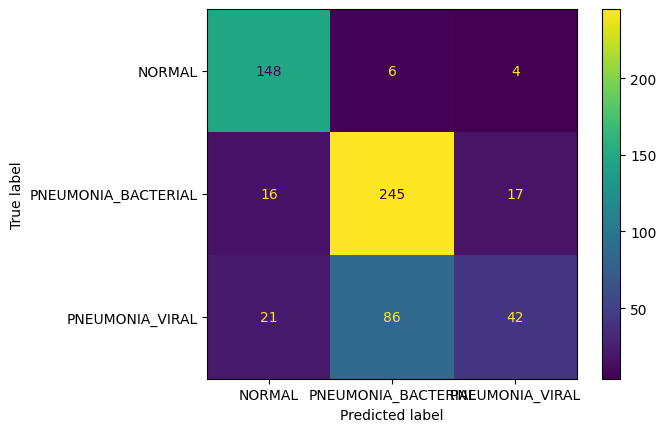

Nombre d'images générées: 5312
x_train (5271, 32, 32, 1) x_test (585, 32, 32, 1)
y_train (5271,) y_test (585,)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 45ms/step - accuracy: 0.4801 - loss: 1.0525 - val_accuracy: 0.6530 - val_loss: 0.9244
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.5781 - loss: 0.9887 - val_accuracy: 0.5675 - val_loss: 0.9810
Epoch 3/50
82/82 - 2s - 26ms/step - accuracy: 0.6288 - loss: 0.8304 - val_accuracy: 0.6581 - val_loss: 0.7882
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.6719 - loss: 0.7665 - val_accuracy: 0.6718 - val_loss: 0.7653
Epoch 5/50
82/82 - 2s - 25ms/step - accuracy: 0.6766 - loss: 0.7406 - val_accuracy: 0.6855 - val_loss: 0.7704
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.6562 - loss: 0.7796 - val_accuracy: 0.6906 - val_loss: 0.7679
Epoch 7/50
82/82 - 2s - 25ms/step - accuracy: 0.6946 - loss: 0.7007 - val_accuracy: 0.7385 - val_loss: 0.6330
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.6719 - loss: 0.6884 - val_accuracy: 0.7162 - val_loss: 0.6719
Epoch 9/50
82/82 - 2s - 25ms/step - accuracy: 0.7092 - loss: 0.6863 - val_accuracy: 0.7402 - val_loss: 0.6214
Epoch 10/

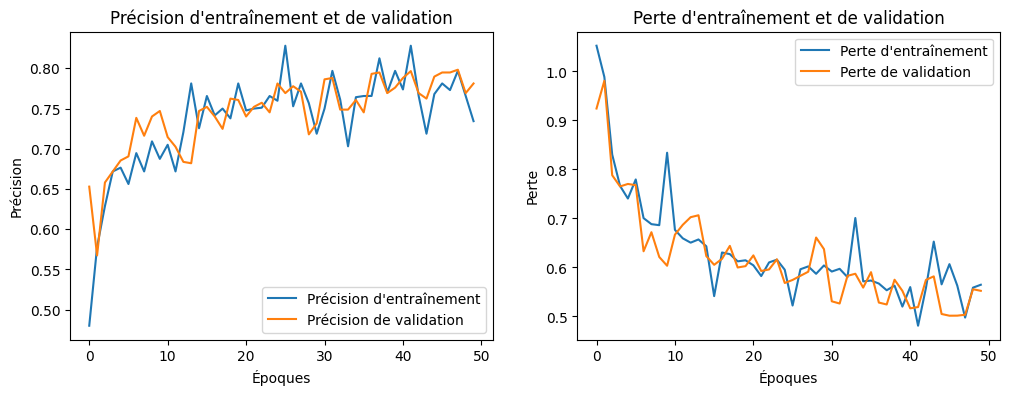

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8334 - loss: 0.4158
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 9:
perte: 0.55 précision: 0.78
AUC 0.8927
Prédictions
Counter({np.int64(1): 296, np.int64(0): 191, np.int64(2): 98}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.79      0.96      0.87       158
Pneumonia_bacteriana       0.80      0.85      0.82       278
     Pneumonia_viral       0.71      0.47      0.57       149

            accuracy                           0.78       585
           macro avg       0.77      0.76      0.75       585
        weighted avg       0.77      0.78      0.77       585

Matrice de confusion


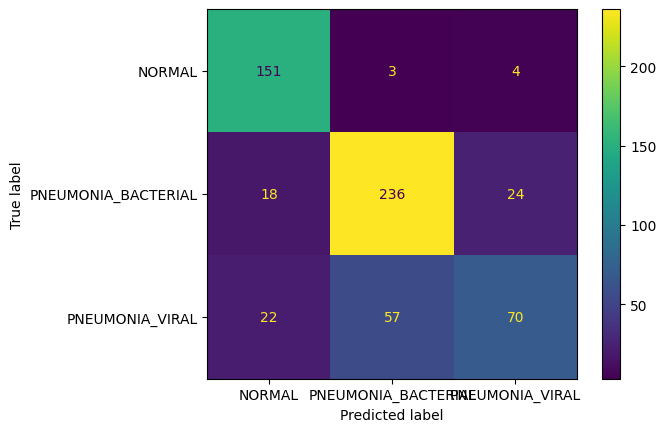

Nombre d'images générées: 5312
x_train (5271, 32, 32, 1) x_test (585, 32, 32, 1)
y_train (5271,) y_test (585,)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,763 (1.41 MB)

 Trainable params: 369,763 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 47ms/step - accuracy: 0.4895 - loss: 1.0294 - val_accuracy: 0.6581 - val_loss: 0.7954
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.6719 - loss: 0.7930 - val_accuracy: 0.5624 - val_loss: 0.9434
Epoch 3/50
82/82 - 2s - 27ms/step - accuracy: 0.6368 - loss: 0.8074 - val_accuracy: 0.6188 - val_loss: 0.8460
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.7344 - loss: 0.7382 - val_accuracy: 0.6650 - val_loss: 0.7543
Epoch 5/50
82/82 - 2s - 26ms/step - accuracy: 0.6810 - loss: 0.7276 - val_accuracy: 0.6786 - val_loss: 0.7819
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.7344 - loss: 0.6706 - val_accuracy: 0.6906 - val_loss: 0.7548
Epoch 7/50
82/82 - 2s - 25ms/step - accuracy: 0.7006 - loss: 0.6934 - val_accuracy: 0.6940 - val_loss: 0.6896
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.6562 - loss: 0.6731 - val_accuracy: 0.6855 - val_loss: 0.7107
Epoch 9/50
82/82 - 2s - 25ms/step - accuracy: 0.7098 - loss: 0.6785 - val_accuracy: 0.7350 - val_loss: 0.6179
Epoch 10/

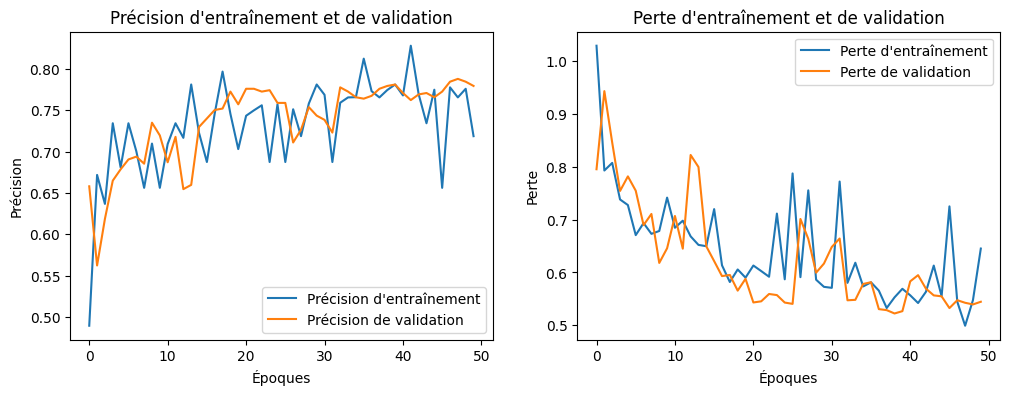

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8326 - loss: 0.4075
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 10:
perte: 0.54 précision: 0.78
AUC 0.8930
Prédictions
Counter({np.int64(1): 296, np.int64(0): 181, np.int64(2): 108}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.83      0.95      0.88       158
Pneumonia_bacteriana       0.79      0.84      0.82       278
     Pneumonia_viral       0.67      0.48      0.56       149

            accuracy                           0.78       585
           macro avg       0.76      0.76      0.75       585
        weighted avg       0.77      0.78      0.77       585

Matrice de confusion


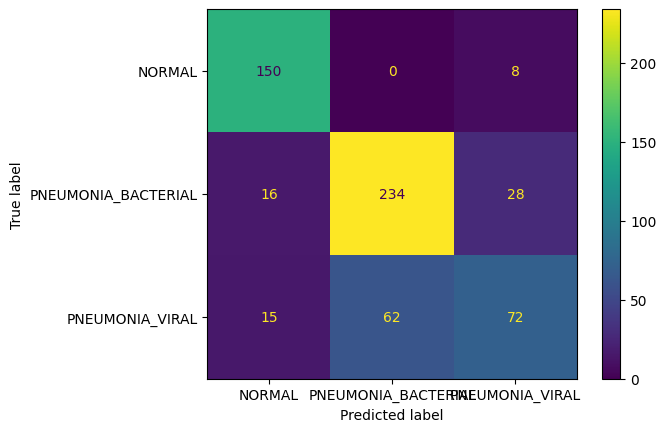

Le meilleur modèle a été sauvegardé avec un ROC de: 0.918741617877374
Fin de l'entraînement
Résultats ROC:
0.8968281404052556

0.918741617877374

0.8785123586141413

0.9144370313283829

0.9089704053428829

0.9174529010752573

0.9042161387613481

0.8791528705209366

0.8927384972106521

0.8929893644702526

Tableau enregistré avec succès dans '2_2_resultatsROC.txt'


In [7]:
def main(path): 
    resultatsROC = []
    
    X, y, input_shape = load_data(path)

    print(X.shape, 'échantillons d\'entraînement')  # Traducción: train samples
    print(img_rows,'x', img_cols, 'taille de l\'image')  # Traducción: image size
    print(input_shape,'input_shape')
    print(epochs,'epochs')

    plot_symbols(X, y)
    collections.Counter(y)

    # Générer des images
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # CV-10
    kf = StratifiedKFold(n_splits=crossValidationSplit, shuffle=True, random_state=123)

    splitEntrenamiento = 1
    meilleur_roc = -1  # Para almacenar el mejor valor de ROC
    meilleur_modele = None  # Para guardar el mejor modelo

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        train_datagen = datagen.flow(X_train, y_train, batch_size=batch_size)

        print("Nombre d'images générées:", len(train_datagen) * batch_size)  # Traducción: Número de imágenes generadas

        print(f'x_train {X_train.shape} x_test {X_test.shape}')
        print(f'y_train {y_train.shape} y_test {y_test.shape}')

        model = cnn_model(input_shape, nb_classes)
        print(model.summary())

        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        history = model.fit(train_datagen, steps_per_epoch=len(X_train) // batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=2)

        # Obtener las métricas del historial
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Graficar la precisión
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(acc, label='Précision d\'entraînement')  # Traducción: Training Accuracy
        plt.plot(val_acc, label='Précision de validation')  # Traducción: Validation Accuracy
        plt.legend()
        plt.title('Précision d\'entraînement et de validation')  # Traducción: Training and Validation Accuracy
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Précision')  # Traducción: Accuracy

        # Graficar la pérdida
        plt.subplot(1, 2, 2)
        plt.plot(loss, label='Perte d\'entraînement')  # Traducción: Training Loss
        plt.plot(val_loss, label='Perte de validation')  # Traducción: Validation Loss
        plt.legend()
        plt.title('Perte d\'entraînement et de validation')  # Traducción: Training and Validation Loss
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Perte')  # Traducción: Loss

        plt.show()

        # Visualizar datos del split
        loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
        y_pred = model.predict(X_test)

        # Guardar datos ROC
        roc = roc_auc_score(y_test, y_pred, multi_class='ovr')
        resultatsROC.append(roc)

        # Guardar el mejor modelo
        if roc > meilleur_roc:
            meilleur_roc = roc
            meilleur_modele = model

        # Graficas sobre Test
        print(f"Partition numéro {splitEntrenamiento}:")  # Traducción: Split número
        print(f'perte: {loss:.2f} précision: {acc:.2f}')  # Traducción: loss, acc
        print(f'AUC {roc:.4f}')

        print('Prédictions')  # Traducción: Predictions
        y_pred_int = y_pred.argmax(axis=1)
        print(collections.Counter(y_pred_int), '\n')

        print('Métriques')  # Traducción: Metrics
        print(metrics.classification_report(y_test, y_pred_int, target_names=['Normal', 'Pneumonia_bacteriana', 'Pneumonia_viral']))

        print('Matrice de confusion')  # Traducción: Confusion matrix
        metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred_int),
                                       display_labels=['NORMAL', 'PNEUMONIA_BACTERIAL','PNEUMONIA_VIRAL']).plot()
        plt.show()

        splitEntrenamiento += 1

    # Guardar el mejor modelo
    if meilleur_modele:
        meilleur_modele.save(r"..\models\meilleur_modele_roc.h5")
        print("Le meilleur modèle a été sauvegardé avec un ROC de:", meilleur_roc)  # Traducción: El mejor modelo fue guardado con un ROC de.

    print("Fin de l\'entraînement")  # Traducción: Fin de entrenamiento
    
    print("Résultats ROC:")  # Traducción: Resultados ROC
    for r in resultatsROC:
        print(f"{r}\n")
        
    enregistrer_tableau_dans_txt(resultatsROC, "2_2_resultatsROC.txt")

if __name__ == '__main__':
    path = r"..\data\external\chest_xray"
    main(path)
